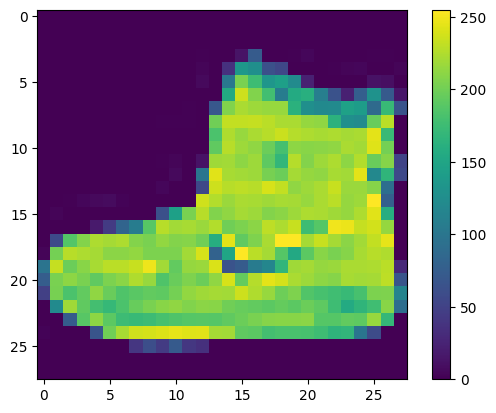

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

train_images = train_images / 255.0

test_images = test_images / 255.0

In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Функція для визначення моделі та гіперпараметрів
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    n_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    for i in range(n_layers):
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=800, step=32) * (n_layers + 1),
            activation='sigmoid'))

    # Dropout для регуляризації
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation=hp.Choice(f'activation_last', values=['softmax', 'sigmoid'])))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Компіляція моделі
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Використання RandomSearch для пошуку оптимальних гіперпараметрів
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    #max_trials=100,  # Кількість експериментів
    directory='my_dir',  # Директорія для збереження результатів
    project_name='fashion_mnist'
)

# Додавання EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Підгонка моделі
tuner.search(train_images, train_labels, epochs=40, validation_split=0.2, callbacks=[early_stopping])

# Отримання оптимальних гіперпараметрів
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal num layers: {best_hps.get('num_layers')}, Optimal learning_rate: {best_hps.get('learning_rate')}")

# Побудова моделі з оптимальними гіперпараметрами
model = tuner.hypermodel.build(best_hps)

# Підгонка остаточної моделі
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Trial 9 Complete [01h 48m 41s]
val_accuracy: 0.8849999904632568

Best val_accuracy So Far: 0.8985000252723694
Total elapsed time: 04h 29m 33s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
544               |320               |units_0
sigmoid           |sigmoid           |activation_0
0.1               |0.2               |dropout
sigmoid           |softmax           |activation_last
0.01              |0.001             |learning_rate
448               |64                |units_1
sigmoid           |sigmoid           |activation_1
448               |736               |units_2
sigmoid           |sigmoid           |activation_2

Epoch 1/40
1055/1500 [====================>.........] - ETA: 49s - loss: 3.2062 - accuracy: 0.0979

In [6]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_2 (Choice)
{'de

313/313 - 1s - loss: 0.3474 - accuracy: 0.8782 - 736ms/epoch - 2ms/step

Test accuracy: 0.8781999945640564
313/313 [==============================] - 1s 2ms/step


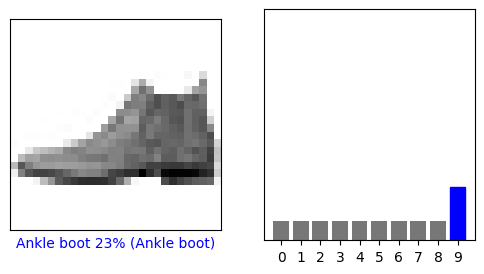

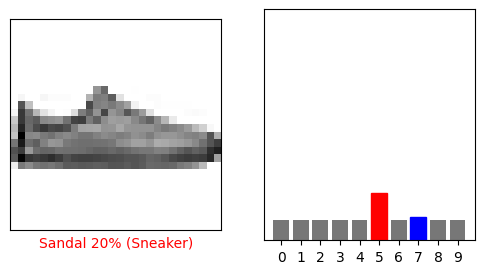

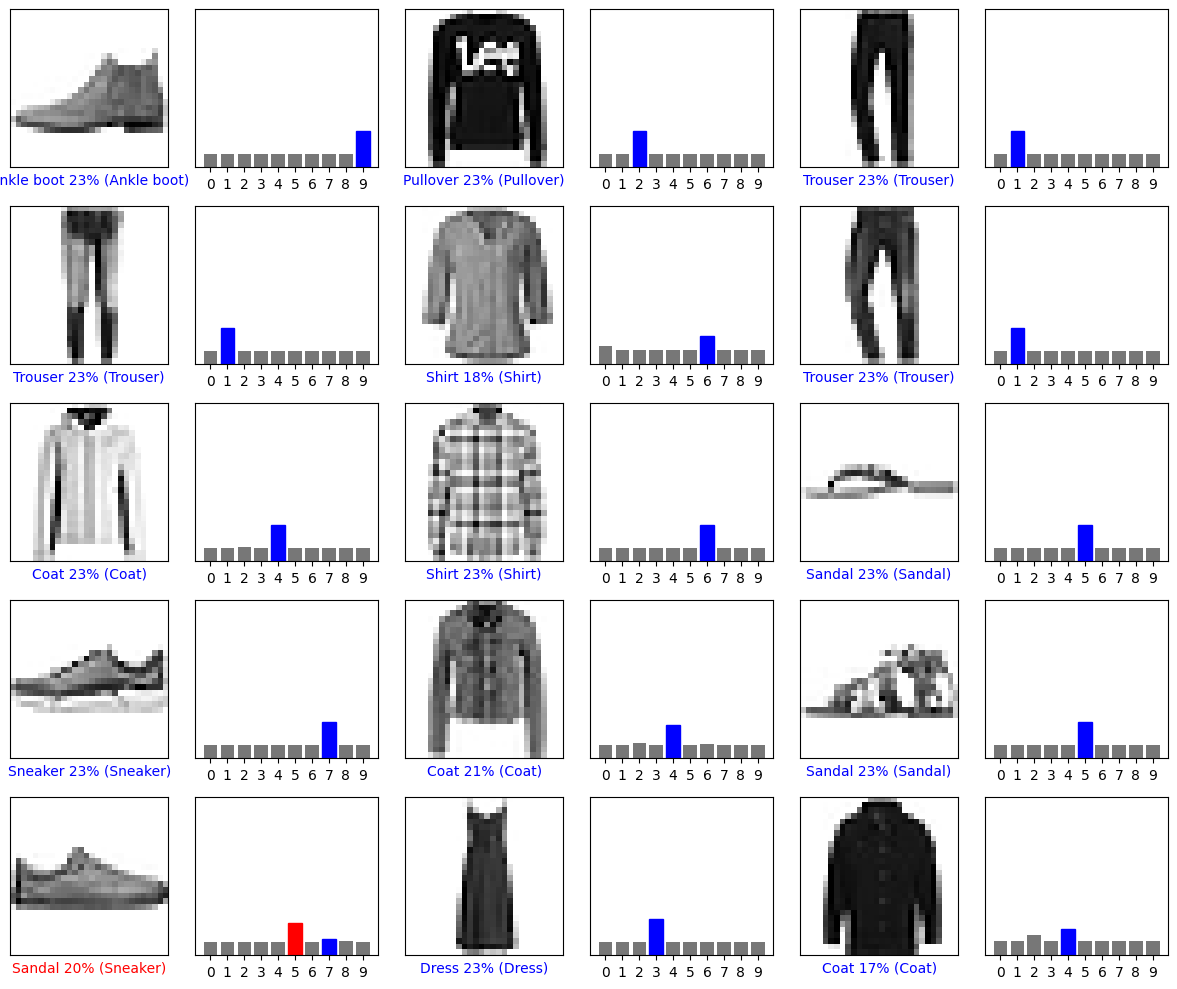

(28, 28)
(1, 28, 28)
1/1 [==============================] - 0s 22ms/step
[[0.08561679 0.08543272 0.23044544 0.08543277 0.08567141 0.08543273
  0.0856699  0.08543272 0.08543275 0.08543272]]


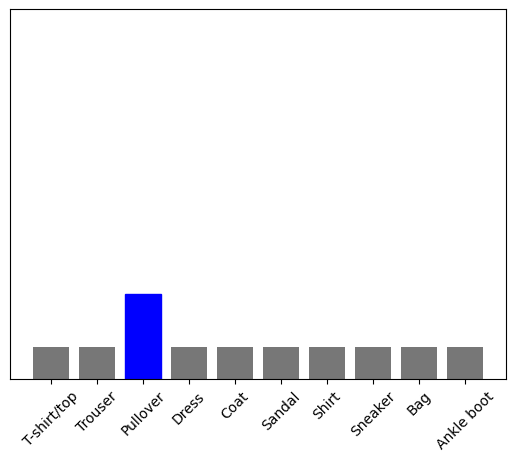

2

In [8]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

predictions[0]

np.argmax(predictions[0])

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

predictions_single = probability_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

np.argmax(predictions_single[0])